
# 3D detailed analysis

Perform detailed 3D stacked and joint analysis.

This tutorial does a 3D map based analsis on the galactic center, using
simulated observations from the CTA-1DC. We will use the high level
interface for the data reduction, and then do a detailed modelling. This
will be done in two different ways:

-  stacking all the maps together and fitting the stacked maps
-  handling all the observations separately and doing a joint fitting on
   all the maps


In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import norm
import astropy.units as u
from regions import CircleSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    Models,
    PointSpatialModel,
    SkyModel,
)

## Check setup



In [2]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()

ModuleNotFoundError: No module named 'gammapy.utils.check'

## Analysis configuration

In this section we select observations and define the analysis
geometries, irrespective of joint/stacked analysis. For configuration of
the analysis, we will programmatically build a config file from scratch.




In [3]:
config = AnalysisConfig()
# The config file is now empty, with only a few defaults specified.
print(config)

# Selecting the observations
config.observations.datastore = "$GAMMAPY_DATA/cta-1dc/index/gps/"
config.observations.obs_ids = [110380, 111140, 111159]

# Defining a reference geometry for the reduced datasets

config.datasets.type = "3d"  # Analysis type is 3D

config.datasets.geom.wcs.skydir = {
    "lon": "0 deg",
    "lat": "0 deg",
    "frame": "galactic",
}  # The WCS geometry - centered on the galactic center
config.datasets.geom.wcs.width = {"width": "10 deg", "height": "8 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# Cutout size (for the run-wise event selection)
config.datasets.geom.selection.offset_max = 3.5 * u.deg
config.datasets.safe_mask.methods = ["aeff-default", "offset-max"]

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.1 TeV"
config.datasets.geom.axes.energy.max = "10 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We now fix the energy axis for the IRF maps (exposure, etc) - (the true energy binning)
config.datasets.geom.axes.energy_true.min = "0.08 TeV"
config.datasets.geom.axes.energy_true.max = "12 TeV"
config.datasets.geom.axes.energy_true.nbins = 14

print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
        n_jobs: 1
        datasets_file: null
        models_file: null
    observations:
        datastore: $GAMMAPY_DATA\hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: null, lon: null, lat: null, radius: null}
        obs_time: {start: null, stop: null}
        required_irf: [aeff, edisp, psf, bkg]
    datasets:
        type: 1d
        stack: true
        geom:
            wcs:
                skydir: {frame: null, lon: null, lat: null}
                binsize: 0.02 deg
                width: {width: 5.0 deg, height: 5.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 2.5 deg}
            axes:
                energy: {min: 1.0 TeV, max: 10.0 TeV, nbins: 5}
                energy_true: {min: 0.5 TeV, max: 20.0 TeV, nbins: 16}
        map_selection: [counts, exposure, background, psf, ed

## Configuration for stacked and joint analysis

This is done just by specifying the flag on `config.datasets.stack`.
Since the internal machinery will work differently for the two cases, we
will write it as two config files and save it to disc in YAML format for
future reference.




In [4]:
config_stack = config.copy(deep=True)
config_stack.datasets.stack = True

config_joint = config.copy(deep=True)
config_joint.datasets.stack = False

# To prevent unnecessary cluttering, we write it in a separate folder.
path = Path("analysis_3d")
path.mkdir(exist_ok=True)
config_joint.write(path=path / "config_joint.yaml", overwrite=True)
config_stack.write(path=path / "config_stack.yaml", overwrite=True)

## Stacked analysis

### Data reduction

We first show the steps for the stacked analysis and then repeat the
same for the joint analysis later




In [5]:
# Reading yaml file:
config_stacked = AnalysisConfig.read(path=path / "config_stack.yaml")

analysis_stacked = Analysis(config_stacked)

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


select observations:



In [6]:
analysis_stacked.get_observations()

# run data reduction
analysis_stacked.get_datasets()

Fetching observations.
Observations selected: 3 out of 3.
Number of selected observations: 3
Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 110380
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 110380
No default lower safe energy threshold defined for obs 110380
Computing dataset for observation 111140
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
No default upper safe energy threshold defined for obs 111140
No default lower safe energy threshold defined for obs 111140
Computing dataset for observation 111159
Running MapDatasetMaker
Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)
Running SafeMaskMaker
No default upper safe energy threshold defined for ob

We have one final dataset, which we can print and explore




In [7]:
dataset_stacked = analysis_stacked.datasets["stacked"]
print(dataset_stacked)

MapDataset
----------

  Name                            : stacked 

  Total counts                    : 121241 
  Total background counts         : 108043.52
  Total excess counts             : 13197.48

  Predicted counts                : 108043.52
  Predicted background counts     : 108043.52
  Predicted excess counts         : nan

  Exposure min                    : 6.28e+07 m2 s
  Exposure max                    : 1.90e+10 m2 s

  Number of total bins            : 2000000 
  Number of fit bins              : 1411180 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




To plot a smooth counts map




In [8]:
dataset_stacked.counts.smooth(0.02 * u.deg).plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

And the background map




In [9]:
dataset_stacked.background.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

We can quickly check the PSF




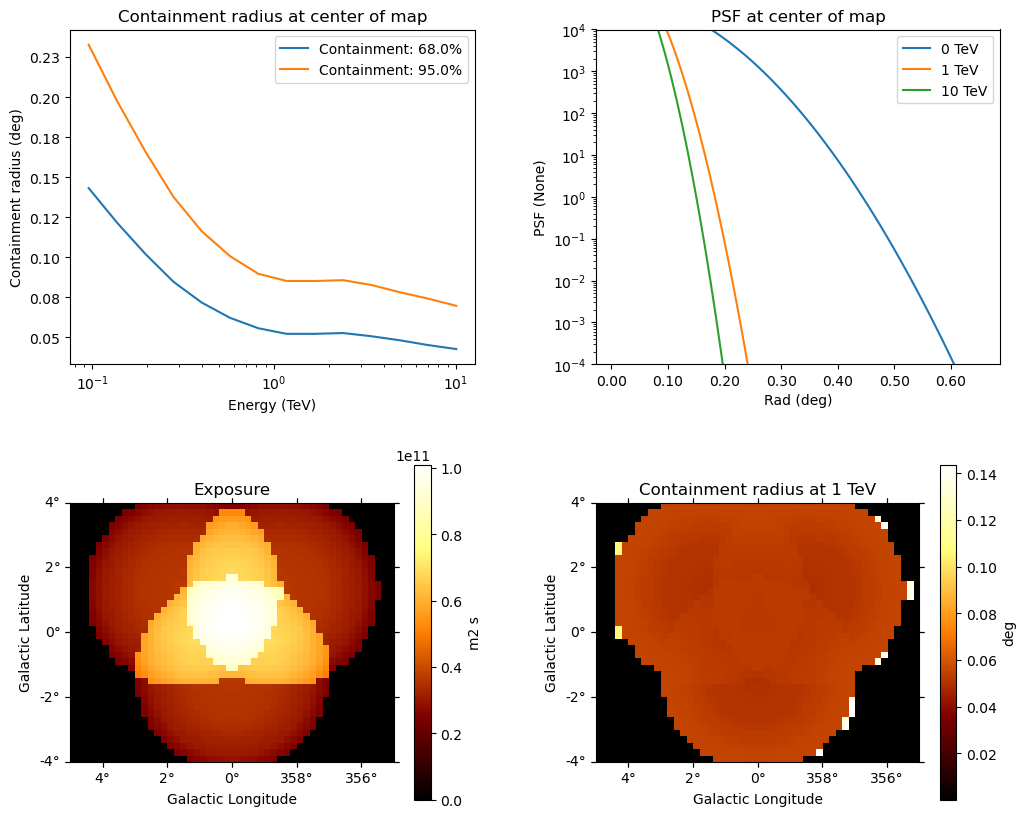

In [10]:
dataset_stacked.psf.peek()

And the energy dispersion in the center of the map




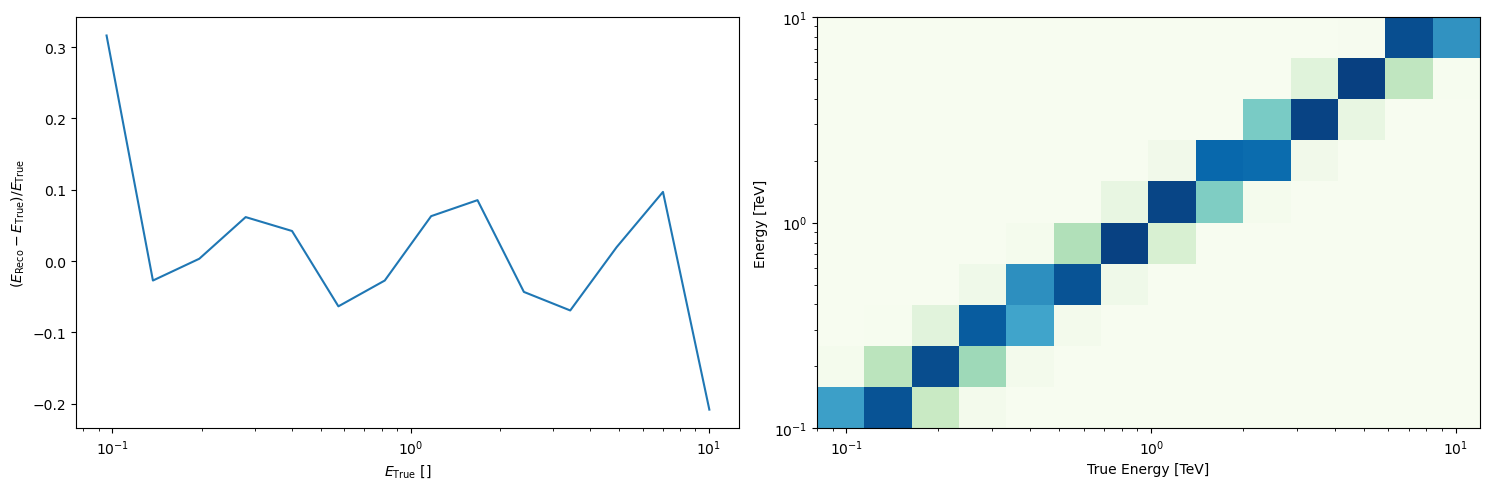

In [11]:
dataset_stacked.edisp.peek()

You can also get an excess image with a few lines of code:




<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

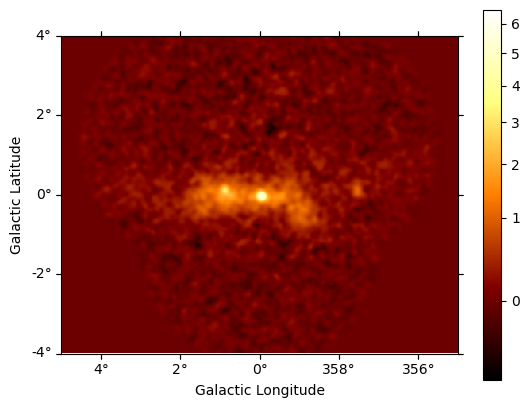

In [12]:
excess = dataset_stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)

### Modeling and fitting

Now comes the interesting part of the analysis - choosing appropriate
models for our source and fitting them.

We choose a point source model with an exponential cutoff power-law
spectrum.




To perform the fit on a restricted energy range, we can create a
specific *mask*. On the dataset, the `mask_fit` is a `Map` sharing
the same geometry as the `MapDataset` and containing boolean data.

To create a mask to limit the fit within a restricted energy range, one
can rely on the `~gammapy.maps.Geom.energy_mask()` method.

For more details on masks and the techniques to create them in gammapy,
please checkou the dedicated :doc:`/tutorials/api/mask_maps` tutorial.




In [31]:
dataset_stacked.mask_fit = dataset_stacked.counts.geom.energy_mask(
    energy_min=0.3 * u.TeV, energy_max=None
)

spatial_model1 = PointSpatialModel(
    lon_0="-0.05 deg", lat_0="-0.05 deg", frame="galactic"
)
spectral_model1 = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model1 = SkyModel(
    spatial_model=spatial_model1,
    spectral_model=spectral_model1,
    name="gc-source",
)
spatial_model2 = PointSpatialModel(
    lon_0="0.8 deg", lat_0="0.05 deg", frame="galactic"
)
spectral_model2 = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model2 = SkyModel(
    spatial_model=spatial_model2,
    spectral_model=spectral_model2,
    name="source2",
)
spatial_model3 = PointSpatialModel(
    lon_0="-2.5 deg", lat_0="0.05 deg", frame="galactic"
)
spectral_model3 = ExpCutoffPowerLawSpectralModel(
    index=2.3,
    amplitude=2.8e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
    lambda_=0.02 / u.TeV,
)

model3 = SkyModel(
    spatial_model=spatial_model3,
    spectral_model=spectral_model3,
    name="source3",
)
bkg_model = FoVBackgroundModel(dataset_name="stacked")
bkg_model.spectral_model.norm.value = 1.3

models_stacked = Models([model1, model2, model3, bkg_model])

dataset_stacked.models = models_stacked

In [32]:
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset_stacked])

### Fit quality assessment and model residuals for a `MapDataset`




We can access the results dictionary to see if the fit converged:




In [33]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1696
	total stat : 180012.34

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



Check best-fit parameters and error estimates:




In [34]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link
str11,str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
gc-source,spectral,index,2.4155e+00,,1.522e-01,nan,nan,False,False,
gc-source,spectral,amplitude,2.6658e-12,cm-2 s-1 TeV-1,3.106e-13,nan,nan,False,True,
gc-source,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,
gc-source,spectral,lambda_,-1.3650e-02,TeV-1,6.837e-02,nan,nan,False,False,
gc-source,spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,
gc-source,spatial,lon_0,-4.8040e-02,deg,2.278e-03,nan,nan,False,False,
gc-source,spatial,lat_0,-5.2615e-02,deg,2.255e-03,-9.000e+01,9.000e+01,False,False,
source2,spectral,index,2.7911e+00,,2.182e-01,nan,nan,False,False,
source2,spectral,amplitude,8.6491e-13,cm-2 s-1 TeV-1,1.531e-13,nan,nan,False,True,


A quick way to inspect the model residuals is using the function
`~MapDataset.plot_residuals_spatial()`. This function computes and
plots a residual image (by default, the smoothing radius is `0.1 deg`
and `method=diff`, which corresponds to a simple `data - model`
plot):




<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

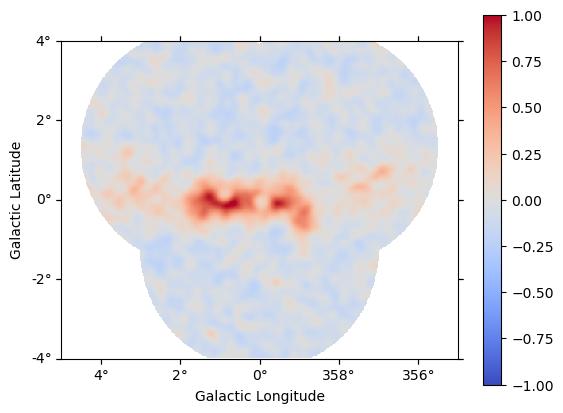

In [35]:
dataset_stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)

The more general function `~MapDataset.plot_residuals()` can also
extract and display spectral residuals in a region:




(<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
 <AxesSubplot:xlabel='Energy [TeV]', ylabel='Residuals (data - model)'>)

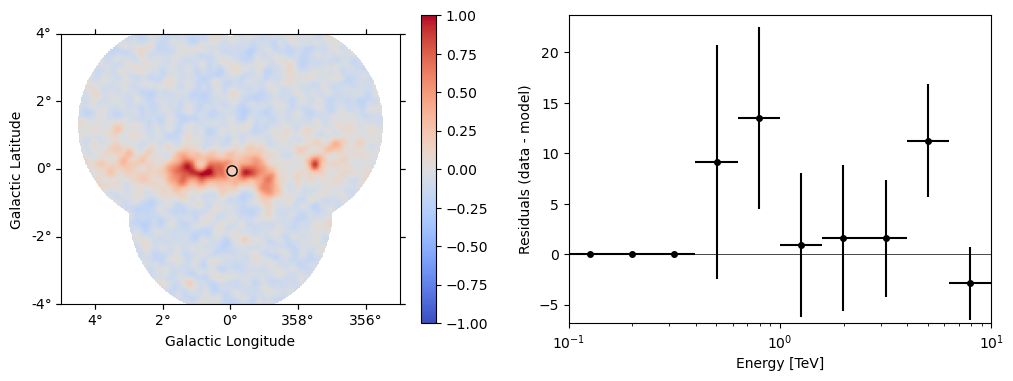

In [30]:
region = CircleSkyRegion(spatial_model1.position, radius=0.15 * u.deg)
dataset_stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)

This way of accessing residuals is quick and handy, but comes with
limitations. For example: - In case a fitting energy range was defined
using a `MapDataset.mask_fit`, it won’t be taken into account.
Residuals will be summed up over the whole reconstructed energy range -
In order to make a proper statistic treatment, instead of simple
residuals a proper residuals significance map should be computed

A more accurate way to inspect spatial residuals is the following:




In [ ]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.1, 1, 10] * u.TeV,
)

result = estimator.run(dataset_stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 4), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)

Distribution of residuals significance in the full map geometry:




In [ ]:
significance_data = result["sqrt_ts"].data

# Remove bins that are inside an exclusion region, that would create an artificial peak at significance=0.
selection = np.isfinite(significance_data)
significance_data = significance_data[selection]

fig, ax = plt.subplots()

ax.hist(significance_data, density=True, alpha=0.9, color="red", bins=40)
mu, std = norm.fit(significance_data)

x = np.linspace(-5, 5, 100)
p = norm.pdf(x, mu, std)

ax.plot(
    x,
    p,
    lw=2,
    color="black",
    label=r"$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(mu, std),
)
ax.legend(fontsize=17)
ax.set_xlim(-5, 5)

## Joint analysis

In this section, we perform a joint analysis of the same data. Of
course, joint fitting is considerably heavier than stacked one, and
should always be handled with care. For brevity, we only show the
analysis for a point source fitting without re-adding a diffuse
component again.

### Data reduction




In [ ]:
# Read the yaml file from disk
config_joint = AnalysisConfig.read(path=path / "config_joint.yaml")
analysis_joint = Analysis(config_joint)

# select observations:
analysis_joint.get_observations()

# run data reduction
analysis_joint.get_datasets()

# You can see there are 3 datasets now
print(analysis_joint.datasets)

You can access each one by name or by index, eg:




In [ ]:
print(analysis_joint.datasets[0])

After the data reduction stage, it is nice to get a quick summary info
on the datasets. Here, we look at the statistics in the center of Map,
by passing an appropriate `region`. To get info on the entire spatial
map, omit the region argument.




In [ ]:
display(analysis_joint.datasets.info_table())

models_joint = Models()

model_joint = model.copy(name="source-joint")
models_joint.append(model_joint)

for dataset in analysis_joint.datasets:
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    models_joint.append(bkg_model)

print(models_joint)

# and set the new model
analysis_joint.datasets.models = models_joint

In [ ]:
fit_joint = Fit()
result_joint = fit_joint.run(datasets=analysis_joint.datasets)

### Fit quality assessment and model residuals for a joint `Datasets`




We can access the results dictionary to see if the fit converged:




In [ ]:
print(result_joint)

Check best-fit parameters and error estimates:




In [ ]:
print(models_joint)

Since the joint dataset is made of multiple datasets, we can either: -
Look at the residuals for each dataset separately. In this case, we can
directly refer to the section
`Fit quality and model residuals for a MapDataset` in this notebook -
Or, look at a stacked residual map.




In [ ]:
stacked = analysis_joint.datasets.stack_reduce()
stacked.models = [model_joint]

plt.figure()
stacked.plot_residuals_spatial(vmin=-1, vmax=1)

Then, we can access the stacked model residuals as previously shown in
the section `Fit quality and model residuals for a MapDataset` in this
notebook.




Finally, let us compare the spectral results from the stacked and joint
fit:




In [ ]:
def plot_spectrum(model, ax, label, color):
    spec = model.spectral_model
    energy_bounds = [0.3, 10] * u.TeV
    spec.plot(
        ax=ax, energy_bounds=energy_bounds, energy_power=2, label=label, color=color
    )
    spec.plot_error(ax=ax, energy_bounds=energy_bounds, energy_power=2, color=color)


fig, ax = plt.subplots()
plot_spectrum(model, ax=ax, label="stacked", color="tab:blue")
plot_spectrum(model_joint, ax=ax, label="joint", color="tab:orange")
ax.legend()
plt.show()

## Summary

Note that this notebook aims to show you the procedure of a 3D analysis
using just a few observations. Results get much better for a more
complete analysis considering the GPS dataset from the CTA First Data
Challenge (DC-1) and also the CTA model for the Galactic diffuse
emission, as shown in the next image:




<img src="file://../../_static/DC1_3d.png">




## Exercises

-  Analyse the second source in the field of view: G0.9+0.1 and add it
   to the combined model.
-  Perform modeling in more details - Add diffuse component, get flux
   points.


